In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

# Background

- Methods to reduce sequential computaiton
    1. the Extented Neural GPU
    2. ByteNet
    3. ConvS2S
- In these models, the number of operations required to relate signals from two arbitary input or output positions, linearly for ConvS2S and logarithmically for ByteNet
- This makes it more difficult to learn dependencies between distant positions

- In the Transformer this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention

# Model Architecture

In [2]:
class EncoderDecoder(nn.Module):
    '''
    A standard Encoder-Decoder architecuture. Base for this and many other models.
    '''
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    

# Encoder and Decoder Stacks

## Encoder
The encoder is composed of a stack of $N = 6$ identical layers.

In [4]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

A residual connection around each of the two sub-layers, followed by layer normalization.

In [6]:
class LayerNorm(nn.Module):
    "Construct a layernorm module"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        # x = [Batch, Seq_len, Embeding 512]
        # self.a_2 * (x - mean) [Batch, Seq, Embedding]
        # self.a2 [512]

        mean = x.mean(-1, keepdim=True) # [B, S, 1]
        std = x.std(-1, keepdim=True)   # [B, S, 1]
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


- The output of each sub-layer is $LayerNorm(x + Sublayer(z))$. 
- We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.
- To faciliatate these residual connetctions, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model} = 512$

> **[Note] Batch Normalization & Layer Normalization**
- BN: Normalizing each feature
- LN : Normalizing each input data
![img](https://yonghyuc.files.wordpress.com/2020/03/bn_vs_ln.png)
- [Ref 1](https://yonghyuc.wordpress.com/2020/03/04/batch-norm-vs-layer-norm/)
- [Ref 2](http://igl-blog.com/tag/normalization/)

- For code simplicity, we emply $x + Sublayer(LayerNorm(x))$ instead of $LayerNorm(x + Sublayer(x))$ 

In [7]:
class SublayerConnection(nn.Module):
    '''
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    '''
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))        


Each Layer has two sub-layers.
1. multi-head self-attention mechanism
2. simple, position-wise fully connected feed- forward network.

In [8]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    
    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

## Decoder
- The decoder is also composed of stack of $N=6$ identical layers.

In [9]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layer, followed by layer normalization.

In [10]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

To prevent positions from attending to subsequent positions, the self-attention sub-layer in the decoder stack is modified.
This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$. 

In [11]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    # Numpy to Torch: triu
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).int()
    return subsequent_mask == 0

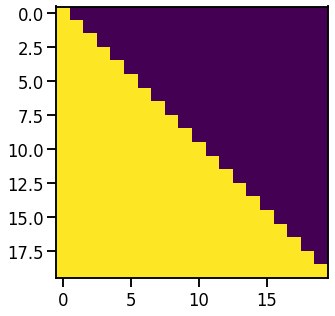

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

# Attention

In [13]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    # [B, S, E] @ [B, E, S] = [B, S, S]
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    # [B, S, S] @ [B, S, E] = [B, S, E]
    return torch.matmul(p_attn, value), p_attn

**Additive attention vs. Scaled Dot-product attention**
- Additive attention([cite](https://arxiv.org/abs/1409.0473)) computes the compatibility function using a feed-forward network with a single hidden layer.
- While both of them are simillar in theoretical complexity, dot-product attention is **much faster and more space-efficient in practice**, since it can be implemented **using highly optimized matrix multiplication code**
- While for small values of $d_k$ the two mechanisms perform simlarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$([cite](https://arxiv.org/abs/1703.03906)).
- We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients(To illustrate why the dot products get large, assume that the componetns of $q$ and $k$ are independent random variables with mean 0 and variance 1. Then their dot product, $q\cdot k = \sum_{i=1}^{d_k}q_{i}k_{i}$, has mean 0 and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.

  
![img](http://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png)

In [14]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equales d_k
        self.d_k = d_model //h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same maske applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
        [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
         for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Applications of Attention in our Model
**The Transformer uses multi-head attention in 3 different ways:**  
1. "Encoder-Decoder Attention"
    - the queries : from the previous decoder layer
    - the memory keys and values : from the output of the encoder
    - It allows every position in the decoder to attend over all positions in the input sequence.
    - This mimics the typical encoder-decoder attention mechanisms in seq2seq models such as [(cite)](https://arxiv.org/abs/1609.08144).

2. "Self-Attention in the Encoder"
    - all of the keys, values and queries come from the same place(the output of the previous layer in the encoder.)
    - Each position in the encoder can attend to all position in the previous layer of the encoder.

3. "Self-Attention in the Decoder"
    - Similar to the case of the Encoder, ecah position in the decoder allowed to attend to all positions in the decoder up to and including that position.
    - To preserve the auto-regressive property, It is need to prevent leftward infomation flow in the decoder.
    - By masking out (setting to -inf) all values in the input of the softmax which correspond to illegal connections, this inside of scaled dot-product attention is implemented

# Position-wise Feed-Foward Networks

Each of the layers in our encoder and decoder contatins a FFN, which is applied to each popsition separately and identically. This consists of two linear transformations with a ReLU activation in between.  
$$ FFN(x) = max(0, xW_1 + b_1 )W_2 + b_2$$  

While the linear transormations are the same across different positions, they use different parameters from layer to layer.
Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output id $d_model = 512$, and the inner-layer has dimensionaltiy $d_{ff} = 2048$.


In [15]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Embeddings and Softmax

Similarly to other sequent transduction models, we use learned embeddings to convert the input tokens and output tokens to vectores of dimension $d_{model}$. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers, we multiply those weights by $\sqrt{d_{model}}$.
  
**[Note] The reason for scaling the embedding weights by $\sqrt{d_{model}}$**
- It is not mentioned on the paper.
- [This post](https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec) says To make the positional encoding relatively smaller.

In [16]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# Positional Encoding

- Since Transformer contains no recurrence and no covolution, in order for the model to make use of the order of the sequence, we must inject information about the relative or absolute position of the tokens in the sequence.
- Dimention : the same dimension to $d_model$ as the embeddings
- Summed to the embeddings
- Choices: Leaned vs Fixed [(cite)](https://arxiv.org/pdf/1705.03122.pdf)

- Sine & Cosine functions of different frequencies:
    - $PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model}})$
    - $PE_{(pos, 2i + 1)} = cos(pos/10000^{2i/d_{model}})$
    - where $pos$ is the position and $i$ is the dimension
    - Each dimension of the positional encoding corresponds to a sinusoid.
    - The wavelengths from a geometric progression from $2\pi$ to $10000 \cdot 2 \pi$
    - We hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos + k}$ can be represented as a linear function of $PE_{pos}$.

- Dropout to the sums of the embeddings and the postional encodings in both the encoder and decoder stacks. For the base model, $P_{drop} = 0.1$.


**[Note] Detailed Discription**
- [Positional Encoding in NLP](https://inmoonlight.github.io/2020/01/26/Positional-Encoding/)

In [17]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe) # static value (Will not updated by optimizer)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                        requires_grad=False)
        return self.dropout(x)


> Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension.

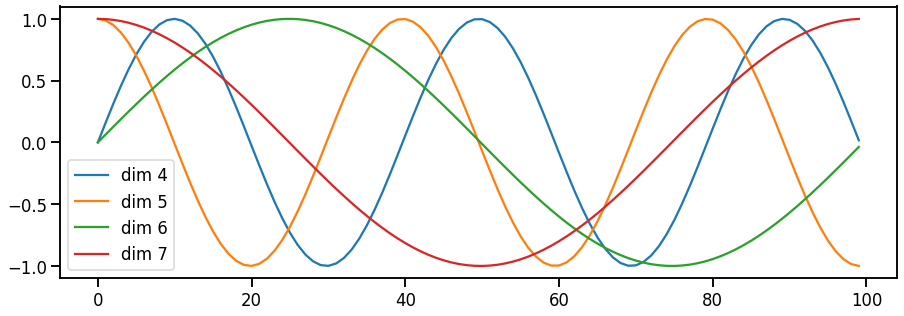

In [18]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

**Learned Positional Embeddings vs. Freezed Positional Embeddings**
- Nearly identical results
- We chose the sinusoidal version because it may allow the model to extrapolate to sequence length longer than ones encounterd during training.

# Full Model

In [19]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p) # fixed
    return model

In [20]:
# Small example model.
tmp_model = make_model(10, 10, 2)

# Training

> We stop for a quick interlude to introduce some of the tools needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as constructing the masks.

## Batches and Masking

In [21]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1] # trg = <s> Hi My Name ...  , trg_y = Hi My Name is
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

> Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles parameter updates.

# Training Loop

In [211]:
def run_epoch(data_iter, model, loss_compute, verbose_term=200):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg,
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % verbose_term == 1:
            elapsed = time.time() - start
            print(f"Epoch Step: {i} Loss: {loss / batch.ntokens} \
             Tokens per Sec: {tokens / elapsed}")
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

# Training Data and Batching

**Dataset**
- the standard WMT 2014 English-German dataset
    - 4.5M sentence pairs
    - Sentencdes were encoded using Byte-Pair Encoding(BPE), which has a shared source-target vocabulary of about 37000 tokens.
- the standard WMT 2014 English-French dataset
    - 36M sentences
    - 32000 word-piece vocabulary.

Sentence pairs were batched together by approximate sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.

> We will use torch text for batching. This is discussed in more detail below. Here we create batches in a torchtext function that ensures our batch size padded to the maximum batchsize does not surpass a threshold (25000 if we have 8 gpus).

In [23]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

# Hardware and Schedule

- 8 P100 GPUs
- Hyperparameters:
    - Base models: Same thing described throughout the paper
- Runtime(per training step):
    - Base models: 0.4 sec
    - Big models: 1.0 sec
- Training time: 
    - Base models: 100,000 steps, 12 hours
    - Big models: 300,000 steps, 3.5 days

# Optimizer

- Adam with $\beta_1 = 0.9, \beta_2 = 0.98$ and $\epsilon = 10^{-9}$.
- Learning rate: varied over the course of training, according to the formula: $lrate = d_{model}^{-0.5}\cdot \textrm{min}(step\_num^{-0.5}, step\_num \cdot warmup\_steps^{-1.5})$
- This is corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse squre root of the step number, We used $warmup\_steps=4000$.
> Note: This part is very important. Need to train with this setup of the model.



In [79]:
class NoamOpt:
    "Optim warpper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer, use_amp=False):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        self.use_amp = use_amp
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.scaler.step(self.optimizer)
        self.scaler.update()
        # self.optimizer.step()
    
    def rate(self, step = None):
        "Implement 'lrate' above"
        if step is None:
            step = self._step
        return self.factor * \
              (self.model_size ** (-0.5) * \
               min(step ** (-0.5), step * self.warmup ** (-1.5)))

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                   torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

> Example of the curves of this model for different model sizes and for optimization hyperparameters.



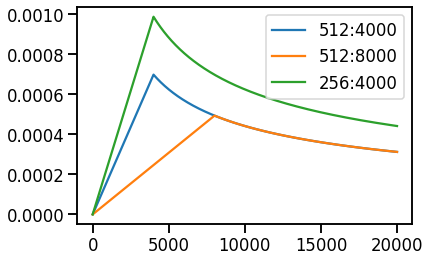

In [80]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None),]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])


# Regularization

## Label Smoothing


- During training, we employed label smoothing of value $\epsilon_{ls} = 0.1$ [(cite](https://arxiv.org/abs/1512.00567). This hurts perpelexity, as the model learns to be more unsure, but improves accuracy and BLEU score.
> We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has **confidence** of the correct word and the rest of the **smoothing** mass distributed throughout the vocabulary.

In [81]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
    
    def forward(self, x, target):
        # print(x.size(1), self.size)
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [82]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])

v = crit(Variable(predict.log()),
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions

### forward method detail

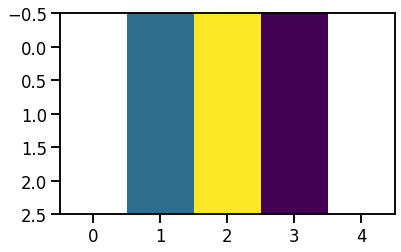

In [83]:
plt.imshow(Variable(predict.log()))

In [84]:
target = Variable(torch.LongTensor([2, 1, 0]))
target

tensor([2, 1, 0])

In [85]:
assert predict.size(1) == crit.size

In [86]:
true_dist = predict.data.clone()
true_dist.fill_(crit.smoothing / (crit.size - 2) )

tensor([[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        [0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        [0.1333, 0.1333, 0.1333, 0.1333, 0.1333]])

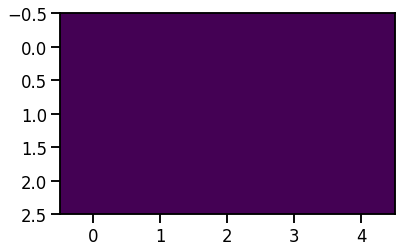

In [87]:
plt.imshow(Variable(true_dist.log()))

In [88]:
target.data.unsqueeze(1)

tensor([[2],
        [1],
        [0]])

In [89]:
true_dist.scatter_(1, target.data.unsqueeze(1), crit.confidence)

tensor([[0.1333, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.1333, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.6000, 0.1333, 0.1333, 0.1333, 0.1333]])

In [90]:
# Remove Padding idx's probability in each logit of token
true_dist[:, crit.padding_idx] = 0
true_dist

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.1333, 0.1333, 0.1333, 0.1333]])

In [91]:
# Masking Padding token's logit
target.data == crit.padding_idx

tensor([False, False,  True])

In [92]:
mask = torch.nonzero(target.data == crit.padding_idx)
mask

tensor([[2]])

In [93]:
mask.dim()

2

In [94]:
mask.squeeze()

tensor(2)

In [95]:
if mask.dim() > 0:
    true_dist.index_fill_(0, mask.squeeze(), 0.0)
true_dist

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

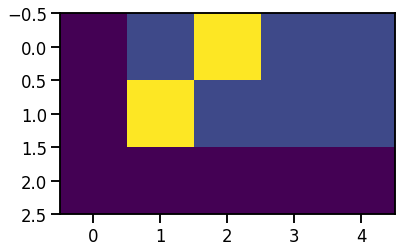

In [96]:
plt.imshow(true_dist)

In [97]:
crit.criterion(predict, Variable(true_dist, requires_grad=False))

tensor(-2.9116)

> Label smoothing actually starts to penalize the model if it gets very confident about a given choice.

In [189]:
crit = LabelSmoothing(5, 0, 0)
def loss(x):
    d = x + 3
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    # print(predict)
    return crit(Variable(predict.log()),
                Variable(torch.LongTensor([1]))).detach()

Text(0.5, 0, 'Over-confidence Degree(from low to high)')

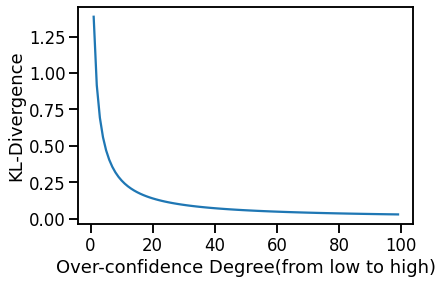

In [190]:
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
plt.ylabel('KL-Divergence')
plt.xlabel('Over-confidence Degree(from low to high)')

In [191]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    # print(predict)
    return crit(Variable(predict.log()),
                Variable(torch.LongTensor([1]))).detach()

Text(0.5, 0, 'Over-confidence Degree(from low to high)')

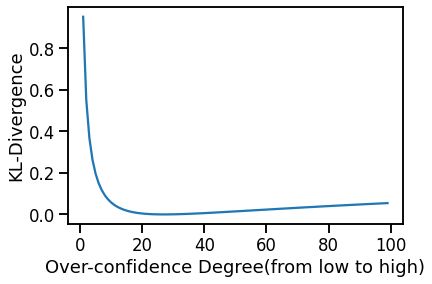

In [192]:
# When the model gets very confident about a given choice, 
# the loss of the model with LS is getting incresed.
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
plt.ylabel('KL-Divergence')
plt.xlabel('Over-confidence Degree(from low to high)')

# A First Example

> We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols.

## Automatic Mixed Precision(AMP)

In [193]:
use_amp = True
scalar = torch.cuda.amp.GradScaler(enabled=use_amp)

## Synthetic Data

In [194]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False).cuda()
        tgt = Variable(data, requires_grad=False).cuda()
        yield Batch(src, tgt, 0)

## Loss Computation

In [195]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None, use_amp=False):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        self.use_amp = use_amp
    
    def __call__(self, x, y, norm):
        with torch.cuda.amp.autocast(enabled=self.use_amp):
            x = self.generator(x)
            # [B, S, E] -> [B*S, E]
            loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                                y.contiguous().view(-1)) / norm
        # loss.backward()
        if self.opt is not None:
            self.opt.scaler.scale(loss).backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.detach() * norm

## Greedy Decoding


In [196]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model.cuda()
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
                    torch.optim.Adam(model.parameters(),
                                    lr=0, betas=(0.9, 0.98), eps=1e-9),
                    use_amp=True)

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model,
              SimpleLossCompute(model.generator, criterion, model_opt, use_amp=True))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model,
                SimpleLossCompute(model.generator, criterion, None)).detach())


Epoch Step: 1 Loss: 3.132861375808716              Tokens per Sec: 7008.87255859375
Epoch Step: 1 Loss: 1.8251698017120361              Tokens per Sec: 24565.603515625
tensor(1.8610, device='cuda:0')
Epoch Step: 1 Loss: 1.9404135942459106              Tokens per Sec: 10693.4912109375
Epoch Step: 1 Loss: 1.6160850524902344              Tokens per Sec: 30950.04296875
tensor(1.6172, device='cuda:0')
Epoch Step: 1 Loss: 1.6778135299682617              Tokens per Sec: 10501.560546875
Epoch Step: 1 Loss: 1.2646641731262207              Tokens per Sec: 36516.30859375
tensor(1.2884, device='cuda:0')
Epoch Step: 1 Loss: 1.4471287727355957              Tokens per Sec: 10343.8671875
Epoch Step: 1 Loss: 1.0967955589294434              Tokens per Sec: 32008.0859375
tensor(1.0923, device='cuda:0')
Epoch Step: 1 Loss: 1.3000785112380981              Tokens per Sec: 9766.6875
Epoch Step: 1 Loss: 0.5936608910560608              Tokens per Sec: 36018.640625
tensor(0.6141, device='cuda:0')
Epoch Step: 1 

**[Note] Need to study Decoding Methods**

> This code predicts a translation using greedy decoding for simplicity.



In [197]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(memory, src_mask,
                           Variable(ys),
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [198]:
model.eval()
src = Variable(torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])).cuda()
src_mask = Variable(torch.ones(1, 1, 10)).cuda()
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]], device='cuda:0')


# A Real World Example

Now we consider a real-world example using the IWSLT German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.

In [113]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


## Data Loading

> We will load the dataset using torchtext and spacy for tokenization.

In [132]:
# For data loading.
from torchtext import datasets
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from collections import Counter, OrderedDict

tokenize_de = get_tokenizer('spacy', 'de')
tokenize_en = get_tokenizer('spacy', 'en')

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = '<blank>'
UNK_WORD = '<unk>' 

MAX_LEN = 100
train_iter, val_iter, test_iter = datasets.IWSLT2016(
                            split=('train', 'valid', 'test'),
                            language_pair=('de','en'))
    
MIN_FREQ = 2

src_counter = Counter()
tgt_counter = Counter()

train = []
for (src, tgt) in train_iter:
    _src = tokenize_de(src.rstrip('\n'))
    _tgt = tokenize_en(tgt.rstrip('\n'))
    if len(_src) <= MAX_LEN and len(_tgt) <= MAX_LEN:
        src_counter.update(_src)
        tgt_counter.update(_tgt)
        train.append((src, tgt))
val = []
for (src, tgt) in val_iter:
    _src = tokenize_de(src.rstrip('\n'))
    _tgt = tokenize_en(tgt.rstrip('\n'))
    if len(_src) <= MAX_LEN and len(_tgt) <= MAX_LEN:
        val.append((src, tgt))
test = []
for (src, tgt) in test_iter:
    _src = tokenize_de(src.rstrip('\n'))
    _tgt = tokenize_en(tgt.rstrip('\n'))
    if len(_src) <= MAX_LEN and len(_tgt) <= MAX_LEN:
        test.append((src, tgt))

specials = [UNK_WORD, BLANK_WORD, BOS_WORD, EOS_WORD]
special_first = True

if specials is not None:
    for tok in specials:
        del src_counter[tok]
        del tgt_counter[tok]

src_sorted_by_freq_tuples = sorted(src_counter.items(),
                                    key=lambda x: x[1], reverse=True)
tgt_sorted_by_freq_tuples = sorted(tgt_counter.items(),
                                    key=lambda x: x[1], reverse=True)

# cf. Original code: Sort by Freq, then by Alphabet
# src_sorted_by_freq_tuples = sorted(src_counter.items(),
#                                     key=lambda x: x[1], reverse=True)
# src_sorted_by_freq_tuples.sort(key=lambda tup: tup[0])
# tgt_sorted_by_freq_tuples = sorted(tgt_counter.items(),
#                                     key=lambda x: x[1], reverse=True)
# tgt_sorted_by_freq_tuples.sort(key=lambda tup: tup[0])

src_ordered_dict = OrderedDict(src_sorted_by_freq_tuples)
tgt_ordered_dict = OrderedDict(tgt_sorted_by_freq_tuples)

# Add speicial tokens 
if specials is not None:
    if special_first:
        specials = specials[::-1]
    for symbol in specials:
        if symbol == BLANK_WORD or symbol == UNK_WORD:
            src_ordered_dict.update({symbol: MIN_FREQ})
            src_ordered_dict.move_to_end(symbol, last=not special_first)
        tgt_ordered_dict.update({symbol: MIN_FREQ})
        tgt_ordered_dict.move_to_end(symbol, last=not special_first)

src_vocab = vocab(src_ordered_dict, MIN_FREQ)
tgt_vocab = vocab(tgt_ordered_dict, MIN_FREQ)

# make default index same as index of UNK_WORD
src_vocab.set_default_index(src_vocab[UNK_WORD])
tgt_vocab.set_default_index(tgt_vocab[UNK_WORD])

2016-01.tgz: 188MB [00:01, 153MB/s]


In [133]:
print("The length of the new vocab is", len(src_vocab), len(tgt_vocab), end='\n\n')
new_src_vocab_stoi = src_vocab.get_stoi()
new_tgt_vocab_stoi = tgt_vocab.get_stoi()

print(f"The index of src vocab's {UNK_WORD} is", new_src_vocab_stoi[UNK_WORD]) 
print(f"The index of src vocab's {BLANK_WORD} is", new_src_vocab_stoi[BLANK_WORD], end='\n\n') 
for i in ([UNK_WORD] + specials):
    print(f"The index of tgt vocab's {i} is", new_tgt_vocab_stoi[i])
print()

new_src_vocab_itos = src_vocab.get_itos()
new_tgt_vocab_itos = tgt_vocab.get_itos()
print("The token at index 2 is", new_src_vocab_itos[2], new_tgt_vocab_itos[2])

The length of the new vocab is 58790 36323

The index of src vocab's <unk> is 0
The index of src vocab's <blank> is 1

The index of tgt vocab's <unk> is 0
The index of tgt vocab's </s> is 3
The index of tgt vocab's <s> is 2
The index of tgt vocab's <blank> is 1
The index of tgt vocab's <unk> is 0

The token at index 2 is , <s>


In [ ]:
# Pretrained weights
# !wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

--2021-06-26 20:42:16--  https://s3.amazonaws.com/opennmt-models/iwslt.pt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.20.133
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.20.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467317581 (446M) [application/x-www-form-urlencoded]
Saving to: ‘iwslt.pt.5’

iwslt.pt.5          100%[===================>] 445.67M  75.3MB/s    in 5.9s    

2021-06-26 20:42:22 (75.2 MB/s) - ‘iwslt.pt.5’ saved [467317581/467317581]



> Not exactly same vocab size compared to original implementation(but quite similar...)

In [ ]:
# model = torch.load('iwslt.pt')
# model.src_embed, model.tgt_embed

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or se

(Sequential(
   (0): Embeddings(
     (lut): Embedding(58794, 512)
   )
   (1): PositionalEncoding(
     (dropout): Dropout(p=0.1, inplace=False)
   )
 ), Sequential(
   (0): Embeddings(
     (lut): Embedding(36321, 512)
   )
   (1): PositionalEncoding(
     (dropout): Dropout(p=0.1, inplace=False)
   )
 ))

## Iterators

In [134]:
def src_text_transform(x):
     return [src_vocab[token] for token in tokenize_de(x)]

def tgt_text_transform(x):
     return [tgt_vocab[BOS_WORD]] + \
            [tgt_vocab[token] for token in tokenize_en(x)] + \
            [tgt_vocab[EOS_WORD]]

In [135]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        src_list.append(torch.tensor(src_text_transform(_src)))
        tgt_list.append(torch.tensor(tgt_text_transform(_tgt)))
    
    # 1.0 is BLANK_WORD's indext number
    return pad_sequence(src_list, padding_value=1.0, batch_first=True), \
           pad_sequence(tgt_list, padding_value=1.0, batch_first=True) 

In [136]:
# Let's check the dataloader's output
train_iter = datasets.IWSLT2016(split=('train'),
                            language_pair=('de','en'))

train_dataloader = DataLoader(list(train_iter), batch_size=2, shuffle=True, 
                              collate_fn=collate_batch)

In [137]:
for _src, _tgt in train_dataloader:
    print(_src, _tgt)
    break

tensor([[   14,  3606,     4,   549,    18,   233,   528,   351,    15,   652,
             2,  2648,     5,    21, 10390,    33,     4,   165,  8646,     3,
             0],
        [   25,  3259,   110,   452,   747,     2,  1605,    11,   270,   110,
            23,  1802,     6,  2576,     3,     0,     1,     1,     1,     1,
             1]]) tensor([[   2,  111, 1883,    6,  636,   50,    6,  263,   70, 6998,    7, 1128,
          301,    4, 3947,    4, 3726,    7,   60,  263,    5,    0,    3],
        [   2,   12,   80,  187,   27, 3079,   28,    6,  468,   12,   80,  112,
           27,    6, 2868,    8,    6, 2938,    5,    0,    3,    1,    1]])


In [138]:
_src.shape

torch.Size([2, 21])

# Multi-GPU Training

> Finally to really target fast training, we will use multi-gpu. This code implements multi-gpu word generation. It is not specific to transformer so I won’t go into too much detail. The idea is to split up word generation at training time into chunks to be processed in parallel across many different gpus. We do this using pytorch parallel primitives:

- replicate - split modules onto different gpus.
- scatter - split batches onto different gpus
- parallel_apply - apply module to batches on different gpus
- gather - pull scattered data back onto one gpu.
- nn.DataParallel - a special module wrapper that calls these all before evaluating.



In [199]:
# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, deivces, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion,
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size

    def __call_(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator,
                                        target_gpus=self.devices)
        out_scatter = nn.parallel.scatter(out, target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets,
                                      target_gpus=self.devices)
        
        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_colunm = [[Variable(o[:, i:i+chunk_size].detach(),
                                    requires_grad=self.opt is not None)]
                            for o in out_scattor]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss.
            y = [(g.contiguous().view(-1, g.size(-1)),
                  t[:, i:i+chunk_size].contiguous().view(-1))
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)
            
            # Sum an normalize loss
            l = nn.parallel.gather(loss, target_device=self.devices[0])

            l = l.sum()[0] / normalize
            total += l.detach()

            # Bacprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())
        
        # Backprop all loss thorough transformer.
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad,
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimzer.zero_grad()
        return total * noramlize

> Now we create our model, criterion, optimizer, data iterators, and paralelization



In [235]:
# GPUs to use
multi_gpu = torch.cuda.device_count() > 1
devices = [range(torch.cuda.device_count())]

pad_idx = new_tgt_vocab_stoi['<blank>']
model = make_model(len(src_vocab), len(tgt_vocab), N=6)
model.cuda()
criterion = LabelSmoothing(size=len(tgt_vocab),
                          padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()
BATCH_SIZE = 25

# TODO: batch_size_fn
train_iter = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, 
                            collate_fn=collate_batch)
valid_iter = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True, 
                            collate_fn=collate_batch)
if multi_gpu:
    model_par = nn.DataParallel(model, device_ids=devices)

> Now we train the model. I will play with the warmup steps a bit, but everything else uses the default parameters. On an AWS p3.8xlarge with 4 Tesla V100s, this runs at ~27,000 tokens per second with a batch size of 12,000

# Training the System

In [ ]:
# Pretrained weights
# !wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

--2021-06-26 20:08:03--  https://s3.amazonaws.com/opennmt-models/iwslt.pt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.85.54
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.85.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467317581 (446M) [application/x-www-form-urlencoded]
Saving to: ‘iwslt.pt.3’

iwslt.pt.3          100%[===================>] 445.67M  75.6MB/s    in 6.3s    

2021-06-26 20:08:09 (70.8 MB/s) - ‘iwslt.pt.3’ saved [467317581/467317581]



In [233]:
# Release GPU Memory
import gc
del model, model_opt, criterion
gc.collect()
torch.cuda.empty_cache()


In [234]:
!nvidia-smi

Sun Jun 27 10:45:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    53W / 300W |   1367MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [236]:
train_from_scratch = True
EPOCH = 2
s_e = 0
if train_from_scratch:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
                    torch.optim.Adam(model.parameters(),
                    lr=0, betas=(0.9, 0.98), eps=1e-9), use_amp=True)
    if multi_gpu:
        for epoch in range(s_e, EPOCH):
            model_par.train()
            run_epoch(
                (Batch(*map(lambda x: x.cuda(), b), pad_idx) for b in train_iter), 
                    model_par, 
                    MultiGPULossCompute(model.generator, criterion, 
                                        devices=devices, opt=model_opt))
            model_par.eval()
            loss = run_epoch(
                (Batch(*map(lambda x: x.cuda(), b), pad_idx) for b in valid_iter), 
                            model_par, 
                            MultiGPULossCompute(model.generator, criterion, 
                            devices=devices, opt=None))
            print(loss)

    else:
        for epoch in range(s_e, EPOCH):
            model.train()
            run_epoch(
                (Batch(*map(lambda x: x.cuda(), b), pad_idx) for b in train_iter),
                    model, SimpleLossCompute(model.generator, criterion, model_opt, use_amp=True))
            model.eval()
            loss = run_epoch(
                (Batch(*map(lambda x: x.cuda(), b), pad_idx) for b in valid_iter),
                 model, SimpleLossCompute(model.generator, criterion, None, use_amp=True))
            print(loss)
else:
    # Can't use this model because of the difference of the vocab.
    model = torch.load('iwslt.pt')

Epoch Step: 1 Loss: 9.119954109191895              Tokens per Sec: 3883.522705078125
Epoch Step: 201 Loss: 5.336925983428955              Tokens per Sec: 5091.51416015625
Epoch Step: 401 Loss: 4.709068775177002              Tokens per Sec: 5128.20947265625
Epoch Step: 601 Loss: 4.507014274597168              Tokens per Sec: 5045.123046875
Epoch Step: 801 Loss: 4.4052276611328125              Tokens per Sec: 5093.86572265625
Epoch Step: 1001 Loss: 4.471973896026611              Tokens per Sec: 5206.5888671875
Epoch Step: 1201 Loss: 4.078723907470703              Tokens per Sec: 5129.06396484375
Epoch Step: 1401 Loss: 4.024282455444336              Tokens per Sec: 5063.8359375
Epoch Step: 1601 Loss: 3.709381341934204              Tokens per Sec: 5190.71875
Epoch Step: 1801 Loss: 3.9943926334381104              Tokens per Sec: 5085.3388671875
Epoch Step: 2001 Loss: 4.20001745223999              Tokens per Sec: 5070.00244140625
Epoch Step: 2201 Loss: 4.043319225311279              Tokens p

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

> Once trained we can decode the model to produce a set of translations. Here we simply translate the first sentence in the validation set. This dataset is pretty small so the translations with greedy search are reasonably accurate.

In [243]:
PATH = 'model_IWSLT2016_basic.pt'
torch.save({'epoch' : epoch,
            'model_state_dict':model.state_dict(),
            'NoamOpt_args' : {'model_size' : model.src_embed[0].d_model,
                            'factor' : 1,
                            'warmup' : 2000,
                            'optimizer_state_dict' : model_opt.optimizer.state_dict()},
            'loss': loss}, PATH)

In [244]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [240]:
!mv model_IWSLT2016_basic.pt drive/MyDrive/job_/

In [241]:
for i, batch in enumerate(valid_iter):
    batch = tuple(map(lambda x : x.cuda(), batch))
    src = batch[0][:1]
    tgt = batch[1][:1]
    src_mask = (src != new_src_vocab_stoi['<blank>']).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=new_tgt_vocab_stoi['<s>'])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = new_tgt_vocab_itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end=' ')
    print()

    print("Source:", end="\t")
    for i in range(1, src.size(1)):
        sym_src = new_src_vocab_itos[src[0, i]]
        if sym_src == "<blank>": continue
        print(sym_src, end=' ')
    print()

    print("Target:", end='\t')
    for i in range(1, tgt.size(1)):
        sym = new_tgt_vocab_itos[tgt[0, i]]
        if sym == '</s>': break
        print(sym, end=' ')
    print()
    break

Translation:	But the guy was going to be a <unk> and he was a very important , and it was a very important , and a very important to be a very important to be a very important to be a very important idea of the first time , and a very important idea of the first time , and 
Source:	hinter den <unk> und dem Frust und der niemals endenden Hyperaktivität war etwas wirklich Einzigartiges : eine reine und unschuldige Natur , ein Junge , der die Welt ohne Vorurteile sah , ein Mensch , der niemals gelogen hatte . <unk> 
Target:	Yet beyond the tantrums and the frustration and the never - ending hyperactivity was something really unique : a pure and innocent nature , a boy who saw the world without prejudice , a human who had never lied . <unk> 


# Additional Components: BPE, Search, Averaging


> So this mostly covers the transformer model itself. There are four aspects that we didn’t cover explicitly. We also have all these additional features implemented in [OpenNMT-py](https://github.com/opennmt/opennmt-py).


> 1) BPE/ Word-piece: We can use a library to first preprocess the data into subword units. See Rico Sennrich’s subword- nmt implementation. These models will transform the training data to look like this:
  
```▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .  ```

  
> 2) Shared Embeddings: When using BPE with shared vocabulary we can share the same weight vectors between the source / target / generator. See the [(cite)](https://arxiv.org/abs/1608.05859) for details. To add this to the model simply do this:

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embed[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

> 3) Beam Search: This is a bit too complicated to cover here. See the [OpenNMT-py](https://github.com/opennmt/opennmt-py). for a pytorch implementation.

> 4) Model Averaging: The paper averages the last k checkpoints to create an ensembling effect. We can do this after the fact if we have a bunch of models:

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        p[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

# Rererences

- [Anotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) 
- [Torchtext 1.0  source code](https://github.com/pytorch/text/tree/master/torchtext)
- [Torchtext 0.4 source code-field](https://github.com/pytorch/text/blob/0.4.0/torchtext/data/field.py)
- [Torchtext 0.4 source code-traslation](https://github.com/pytorch/text/blob/0.4.0/torchtext/datasets/translation.py)
- [Torchtext 0.4 Document](https://github.com/pytorch/text/blob/0.4.0/torchtext/data/field.py)
- [Torchtext 0.8 NMT Tutorial](https://tutorials.pytorch.kr/beginner/torchtext_translation.html)
- [Torchtext 0.9.0 release note](https://github.com/pytorch/text/releases/tag/v0.9.0-rc5)
- [Torchtext 0.8->0.9 migration tutorial](https://github.com/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb)
- https://towardsdatascience.com/understanding-transformers-the-programming-way-f8ed22d112b2

- [PyTorch AMP Document](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html)